# PCA

In [1]:
! pip install --quiet --upgrade nltk > /dev/null

In [2]:
# make a tag for this run
import datetime
import os

# Process the sentences
import re
import string
import warnings

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN, KMeans

# importing libraries to use
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler

from project_utilities import upload_to_s3

nltk.download("all", quiet=True)

True

In [4]:
# Identify the working directory and data files
working_directory = "33-PCA-TSNE-KMeans-DBSCAN"

# Create the working directory if needed
try:
    os.makedirs(working_directory, exist_ok=True)
except OSError as error:
    print(f"Error creating {working_directory}: {error}")

In [5]:
df = pd.read_pickle("./21-Preprocess-Combined-Data-v2/dataframe.pickle")

In [6]:
verification_row = 9
n_components = 25

In [7]:
TAG = f"{datetime.datetime.now():%Y_%m_%d_%s}"

In [8]:
scores = {}

In [9]:
df.shape

(5736, 20)

In [10]:
df.head()

ROW_ID                                           FOI_TEXT  \
0  1969025  IT WAS REPORTED THAT THE TRANSMITTER LOST CONN...   
1  1426265  IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...   
2  2609625  IT WAS REPORTED THAT TRANSMITTER FAILED ERROR ...   
3  2813837  IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...   
4  1337517  IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...   

  DEVICE_PROBLEM_CODE             DEVICE_PROBLEM_TEXT  \
0                3283  Wireless Communication Problem   
1                3283  Wireless Communication Problem   
2                1435                No Device Output   
3                3283  Wireless Communication Problem   
4                3283  Wireless Communication Problem   

                 GENERIC_NAME DEVICE_REPORT_PRODUCT_CODE          UDI-DI  \
0  CONTINUOUS GLUCOSE MONITOR                        QBJ                   
1  CONTINUOUS GLUCOSE MONITOR                        QBJ  00386270000385   
2  CONTINUOUS GLUCOSE MONITOR                        QBJ  00386270000385   
3  CONTINUOUS GLUCOSE MONITOR                        QBJ  00386270000385   
4  CONTINUOUS GLUCOSE MONITOR                        QBJ  00386270000385   

       UDI-PUBLIC DATE_OF_EVENT REPORTER_OCCUPATION_CODE REPORT_DATE  \
0                    07/30/2020                      000               
1  00386270000385    06/05/2020                      000               
2  00386270000385    10/05/2020                      000               
3  00386270000385    10/23/2020                      000               
4  00386270000385    05/25/2020                      000               

  EVENT_LOCATION SOURCE_TYPE  \
0              I    CONSUMER   
1              I    CONSUMER   
2              I    CONSUMER   
3              I    CONSUMER   
4              I    CONSUMER   

                                      TOKENIZED_TEXT  \
0  [it, was, reported, that, the, transmitter, lo...   
1  [it, was, reported, that, signal, loss, over, ...   
2  [it, was, reported, that, transmitter, failed,...   
3  [it, was, reported, that, signal, loss, over, ...   
4  [it, was, reported, that, signal, loss, over, ...   

                                        NOPUNCT_TEXT  \
0  [it, was, reported, that, the, transmitter, lo...   
1  [it, was, reported, that, signal, loss, over, ...   
2  [it, was, reported, that, transmitter, failed,...   
3  [it, was, reported, that, signal, loss, over, ...   
4  [it, was, reported, that, signal, loss, over, ...   

                                    NOSTOPWORDS_TEXT  \
0  [reported, transmitter, lost, connection, pump...   
1  [reported, signal, loss, one, hour, occurred, ...   
2  [reported, transmitter, failed, error, occurre...   
3  [reported, signal, loss, one, hour, occurred, ...   
4  [reported, signal, loss, one, hour, occurred, ...   

                                       NODIGITS_TEXT  \
0  [reported, transmitter, lost, connection, pump...   
1  [reported, signal, loss, one, hour, occurred, ...   
2  [reported, transmitter, failed, error, occurre...   
3  [reported, signal, loss, one, hour, occurred, ...   
4  [reported, signal, loss, one, hour, occurred, ...   

                                            POS_TEXT  \
0  [(reported, VBN), (transmitter, NN), (lost, VB...   
1  [(reported, VBN), (signal, JJ), (loss, NN), (o...   
2  [(reported, VBN), (transmitter, NN), (failed, ...   
3  [(reported, VBN), (signal, JJ), (loss, NN), (o...   
4  [(reported, VBN), (signal, JJ), (loss, NN), (o...   

                                     LEMMATIZED_TEXT  \
0  [report, transmitter, lose, connection, pump, ...   
1  [report, signal, loss, one, hour, occur, produ...   
2  [report, transmitter, fail, error, occur, data...   
3  [report, signal, loss, one, hour, occur, revie...   
4  [report, signal, loss, one, hour, occur, produ...   

                                        STEMMED_TEXT  
0  [report, transmitt, lost, connect, pump, great...  
1  [report, signal, loss, one, hour, occur, produ...  


In [11]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
# create a DataFrame for the sentences
sentences_df = pd.DataFrame(
    columns=[
        "SENTENCE_ID",
        "SENTENCE",
        "ROW_ID",
        "FOI_TEXT",
        "DEVICE_PROBLEM_CODE",
        "DEVICE_PROBLEM_TEXT",
    ]
)

# Iterate over every row in the FOI_TEXT DataFrame
# and create a new dataframe with a row for each sentence.
# Each row will have a sentence, the orginal ROW_ID, and the
# FOI_TEXT that it came from along with the DEVICE_PROBLEM_CODE and
# DEVICE_PROBLEM_TEXT from the orginal FOI_TEXT
sentence_counter = 0

for index, row in df.iterrows():
    for sentence in nltk.sent_tokenize(row["FOI_TEXT"]):
        sentence_data = {
            "SENTENCE": sentence,
            "SENTENCE_ID": sentence_counter,
            "ROW_ID": row["ROW_ID"],
            "FOI_TEXT": row["FOI_TEXT"],
            "DEVICE_PROBLEM_CODE": row["DEVICE_PROBLEM_CODE"],
            "DEVICE_PROBLEM_TEXT": row["DEVICE_PROBLEM_TEXT"],
        }
        sentence_data_df = pd.DataFrame(sentence_data, index=[sentence_counter])
        sentences_df = pd.concat([sentences_df, sentence_data_df])
        sentence_counter = sentence_counter + 1

In [13]:
sentences_df.shape

(25686, 6)

In [14]:
sentences_df.head()

SENTENCE_ID                                           SENTENCE   ROW_ID  \
0           0  IT WAS REPORTED THAT THE TRANSMITTER LOST CONN...  1969025   
1           1  THE TRANSMITTER ULTIMATELY REGAINED CONNECTION...  1969025   
2           2  NO ADDITIONAL PATIENT OR EVENT INFORMATION WAS...  1969025   
3           3  IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...  1426265   
4           4    NO PRODUCT OR DATA WAS PROVIDED FOR EVALUATION.  1426265   

                                            FOI_TEXT DEVICE_PROBLEM_CODE  \
0  IT WAS REPORTED THAT THE TRANSMITTER LOST CONN...                3283   
1  IT WAS REPORTED THAT THE TRANSMITTER LOST CONN...                3283   
2  IT WAS REPORTED THAT THE TRANSMITTER LOST CONN...                3283   
3  IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...                3283   
4  IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...                3283   

              DEVICE_PROBLEM_TEXT  
0  Wireless Communication Problem  
1  Wireless Communication Problem  
2  Wireless Communication Problem  
3  Wireless Communication Problem  
4  Wireless Communication Problem

In [15]:
sentences_df["SENTENCE"][verification_row]

'THE PROBABLE CAUSE COULD NOT BE DETERMINED.'

In [16]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
stop_words = set(stopwords.words("english"))
punctuations = set(string.punctuation)


def process_sentence(sentence):
    # Lowercase the sentence
    sentence = sentence.lower()

    # Remove any words that start with a digit
    sentence = re.sub(r"\b\d\w*\b", "", sentence)

    # Remove punctuation
    sentence_tokens = sentence.split()
    sentence_tokens = [
        token.translate(str.maketrans("", "", string.punctuation))
        for token in sentence_tokens
    ]

    # Remove stopwords
    sentence_tokens = [token for token in sentence_tokens if token not in stop_words]
    sentence = " ".join(sentence_tokens)

    return sentence


sentences_df["PROCESSED_SENTENCE"] = sentences_df["SENTENCE"].apply(process_sentence)

In [18]:
sentences_df["PROCESSED_SENTENCE"][verification_row]

'probable cause could determined'

In [20]:
%pip install --upgrade --quiet sentence-transformers hdbscan mpld3 sentence_transformers

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# define the document embedding model
# https://www.sbert.net/docs/pretrained_models.html
embedder = SentenceTransformer("all-MiniLM-L6-v2")
embedded_sentences = embedder.encode(sentences_df["PROCESSED_SENTENCE"])
embedded_sentences

In [22]:
scaler = MinMaxScaler()

# "np.array([i for i in df['EMBED']])" Converts the data into a 2d array
embedded_sentences_scaled = scaler.fit_transform(
    np.array([i for i in embedded_sentences])
)

In [23]:
embedded_sentences_scaled

array([[0.5719789 , 0.6762022 , 0.4889078 , ..., 0.55340743, 0.36013085,
        0.40519148],
       [0.4158448 , 0.45435464, 0.49014124, ..., 0.61890954, 0.53317845,
        0.40002647],
       [0.57373285, 0.65782815, 0.3288343 , ..., 0.60889244, 0.57444024,
        0.52802426],
       ...,
       [0.26949558, 0.80179   , 0.3676664 , ..., 0.47699833, 0.861899  ,
        0.70197856],
       [0.5644342 , 0.3526276 , 0.60742104, ..., 0.33022082, 0.5997228 ,
        0.30757672],
       [0.68828   , 0.67717063, 0.63736176, ..., 0.33055103, 0.750519  ,
        0.688387  ]], dtype=float32)

In [24]:
# Vectorize the sentences using TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorized_sentences = vectorizer.fit_transform(sentences_df["PROCESSED_SENTENCE"])
vectorized_sentences

<25686x1050 sparse matrix of type '<class 'numpy.float64'>'
	with 134036 stored elements in Compressed Sparse Row format>

In [25]:
# Combine the embeddings and vectorized sentences into a single feature matrix
feature_matrix = pd.concat(
    [
        pd.DataFrame(embedded_sentences_scaled),
        pd.DataFrame(vectorized_sentences.toarray()),
    ],
    axis=1,
)

In [26]:
feature_matrix.shape

(25686, 1434)

In [27]:
warnings.filterwarnings("ignore")

In [28]:
# Performing PCA with 10 components
pca = PCA(n_components=10)

# applying pca on the data
pca.fit(feature_matrix)

# getting pca components
pca_components = pca.fit_transform(feature_matrix)

# getting explained variance ratio
explained_var = pca.explained_variance_ratio_

# making components
components = ["PC" + str(i) for i in range(1, len(explained_var) + 1)]

# Creating a dataframe of the explained variance ratio for each component
ev_df = pd.DataFrame(
    {"Component": components, "Explained Variance Ratio": explained_var}
)
ev_df = ev_df.sort_values(by="Explained Variance Ratio", ascending=False)

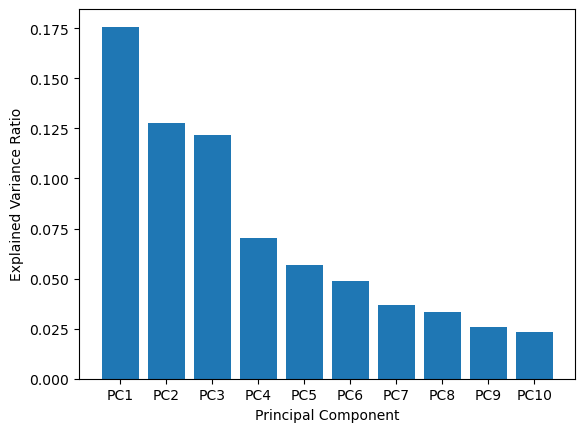

In [29]:
# Ploting the explained variance ratio for each component
plt.bar(ev_df["Component"], ev_df["Explained Variance Ratio"])
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.show()

Text(0, 0.5, 'Explained Variance')

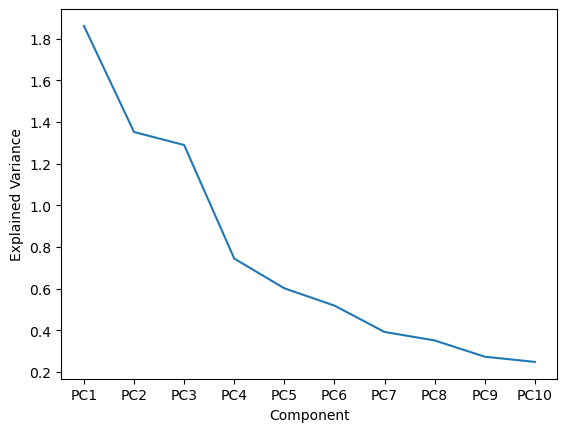

In [30]:
# making a line chart to visualize the explained variance
components_name = ev_df["Component"]
sns.lineplot(x=components_name, y=pca.explained_variance_)
plt.ylabel("Explained Variance")

In [31]:
# Calculate the total explained variance
total_explained_variance = sum(pca.explained_variance_)

print(f"Total explained variance: {total_explained_variance*10:.4f}")

Total explained variance: 76.3063


In [32]:
cumulative_explained_variance_df = pd.DataFrame(
    {
        "Number of Components": range(1, len(np.cumsum(pca.explained_variance_)) + 1),
        "Cumulative Explained Variance": np.cumsum(
            np.round(pca.explained_variance_ratio_, decimals=3) * 100
        ),
    }
)

cumulative_explained_variance_df

Number of Components  Cumulative Explained Variance
0                     1                           17.6
1                     2                           30.4
2                     3                           42.6
3                     4                           49.6
4                     5                           55.3
5                     6                           60.2
6                     7                           63.9
7                     8                           67.2
8                     9                           69.8
9                    10                           72.1

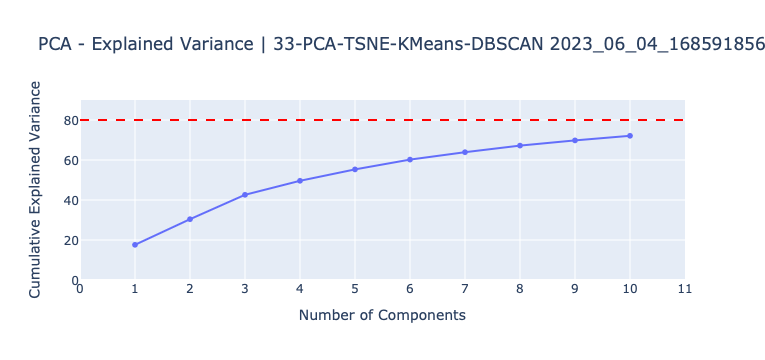

In [77]:
fig_1 = px.line(
    cumulative_explained_variance_df,
    x="Number of Components",
    y="Cumulative Explained Variance",
    title=f"PCA - Explained Variance | {working_directory} {TAG}\n",
)

# add markers for each point
fig_1.update_traces(mode="lines+markers")

# extend the limits of the y-axis from 0 to 90
fig_1.update_yaxes(range=[0, 90])

# extend the limits of the x-axis from 0 to 16
fig_1.update_xaxes(range=[0, 11])

# add a horizontal rule for y = 80
fig_1.add_shape(
    type="line", x0=0, y0=80, x1=27, y1=80, line=dict(color="red", width=2, dash="dash")
)

# show all numbers on the x-axis
fig_1.update_layout(xaxis=dict(tickmode="linear"))

# write the graph to a file in the working directory
fig_1.write_html(
    f"{working_directory}/pca_explained_variance_with_{n_components}_components_{TAG}.html"
)

# show the plot
fig_1.show()

In [34]:
# Choosing the  3 principal components
pca = PCA(n_components=3)

# applying on data
pca.fit(feature_matrix)

# converting data
pca_df = pd.DataFrame(pca.transform(feature_matrix), columns=["PC1", "PC2", "PC3"])

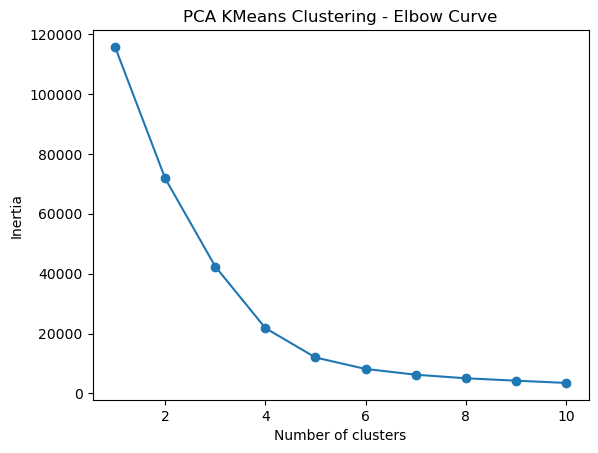

In [35]:
# making an empty list to store inertia for each cluster
inertias = []

# Performing KMeans clustering with 1 to 10 clusters
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_df)
    inertias.append(kmeans.inertia_)

# Ploting the elbow curve
plt.plot(range(1, 11), inertias, marker="o")
plt.title("PCA KMeans Clustering - Elbow Curve")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

- After 5 clusters the change in inertia is not significant

# PCA KMeans Clustering

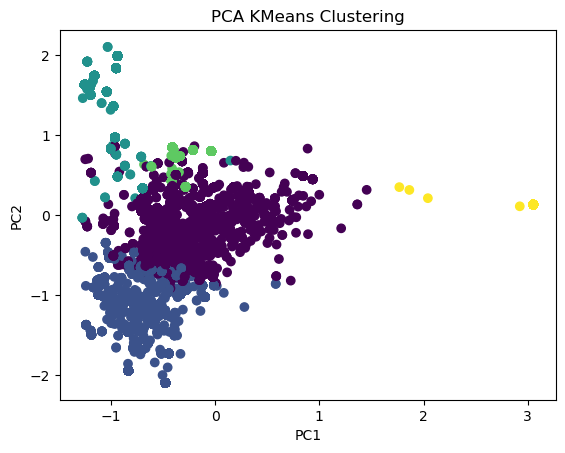

In [36]:
# Choose the number of clusters based on the elbow method
kmeans = KMeans(n_clusters=5, random_state=42)

# applying the kmeans clustering on the dataset obtained after applying pca for 3 components
kmeans.fit(pca_df)

# getting labels
y_pred_pca = kmeans.fit_predict(pca_df)
kmeans_labels = kmeans.labels_

# Visualize the clustering results in 2D using the first two principal components
plt.scatter(pca_df["PC1"], pca_df["PC2"], c=kmeans_labels)
plt.title("PCA KMeans Clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

- Silhouette Score is a measure of how similar an object is to its own cluster compared to other clusters. It ranges from -1 to 1. A score of 1 indicates that the object is perfectly matched to its own cluster, and a score of -1 indicates that the object is better matched to a different cluster.

In [37]:
# Compute the silhouette score
score = silhouette_score(pca_df, y_pred_pca)
scores["PCA KMeans Clustering"] = score

print("Silhouette Score for PCA KMeans Clustering: ", score)

Silhouette Score for PCA KMeans Clustering:  0.6229034440278266


In [38]:
# adding cluster labels to the sentence df
sentences_df["PCA_CLUSTER"] = kmeans_labels

# PCA DBSCAN Clustering

In [39]:
eps = [0.75, 0.5, 0.31, 0.31, 0.75, 1, 1, 0.5, 2, 2, 3, 3]
min_samples = [2, 2, 2, 4, 4, 2, 4, 4, 2, 4, 2, 4]

dbscan_pca_collection = []
dbscan_pca_labels_collection = []

for i in range(0, len(eps)):
    # Performing DBSCAN clustering
    dbscan_pca_collection.append(DBSCAN(eps=eps[i], min_samples=eps[i]))

    # getting labels for components obtained after applying pca
    dbscan_pca_labels_collection.append(dbscan_pca_collection[i].fit_predict(pca_df))

    # adding cluster labels to the sentence df
    sentences_df[
        f"PCA_DBSCAN_CLUSTER_{eps[i]}_{eps[i]}"
    ] = dbscan_pca_labels_collection[i]

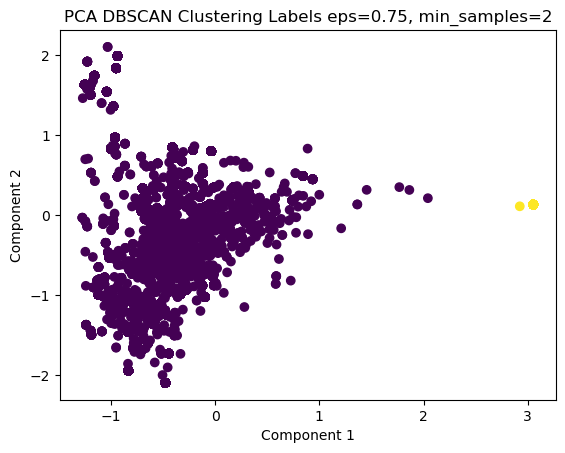

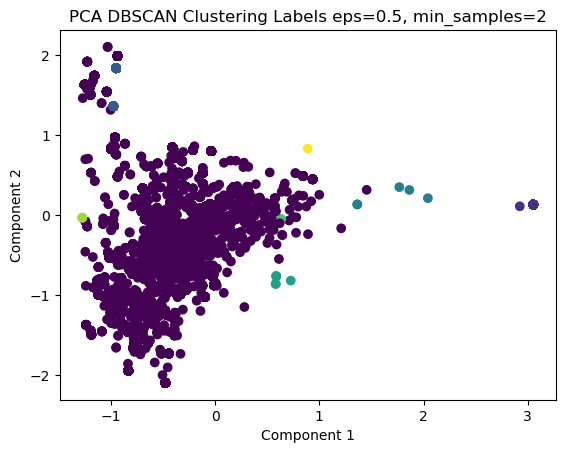

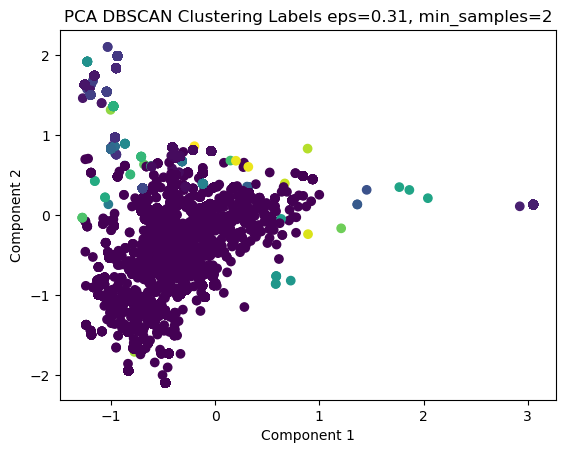

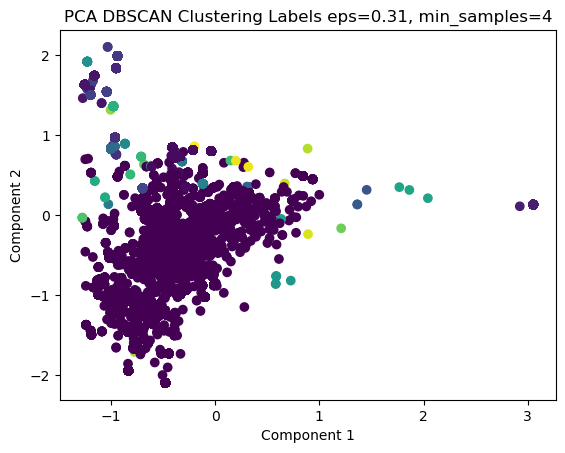

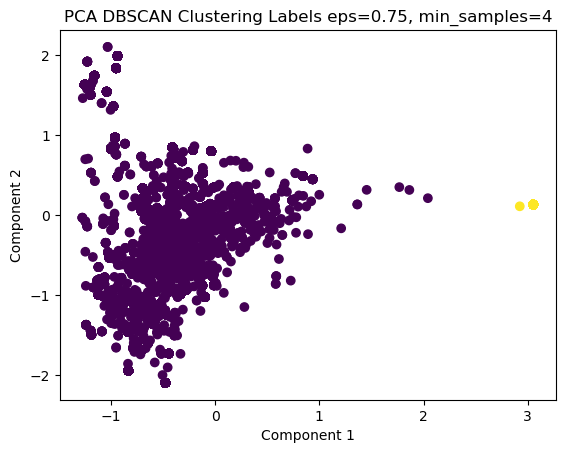

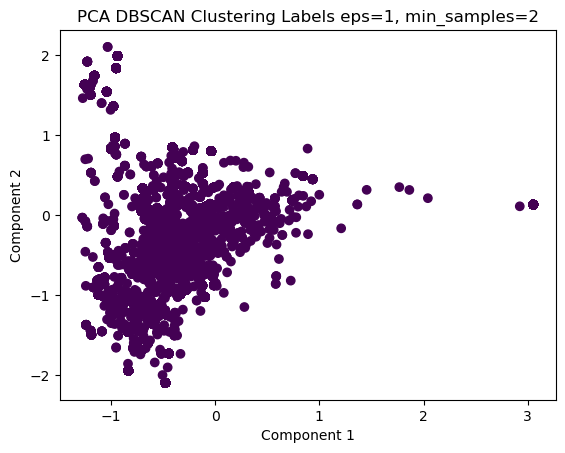

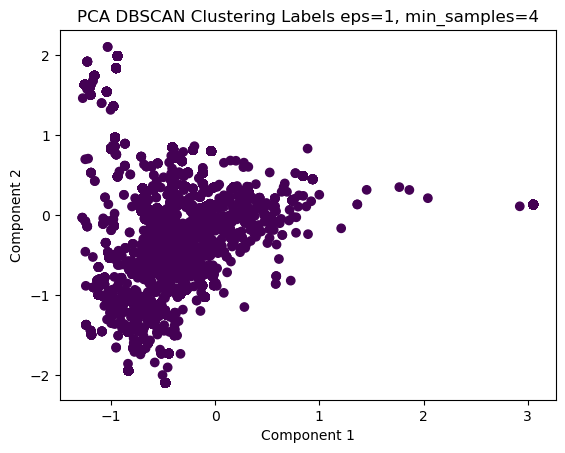

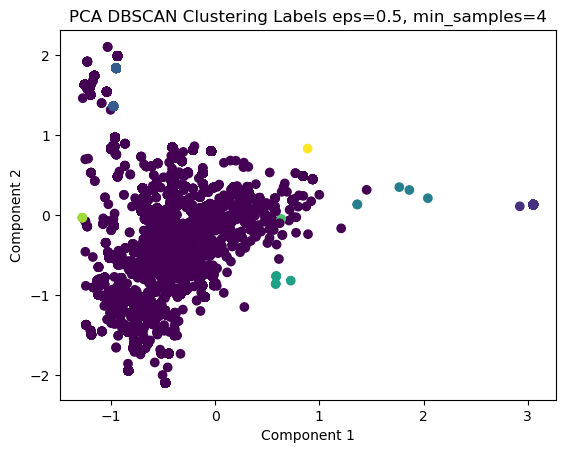

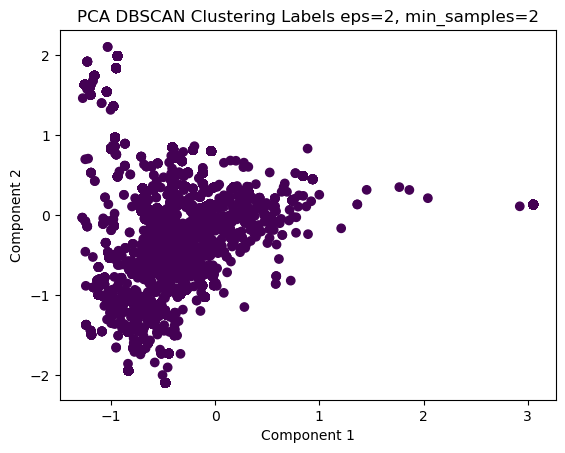

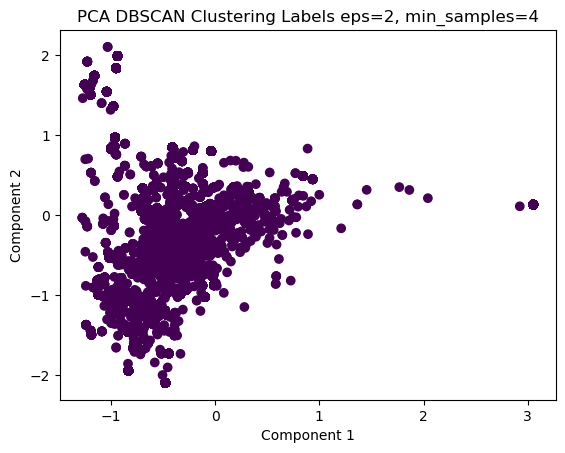

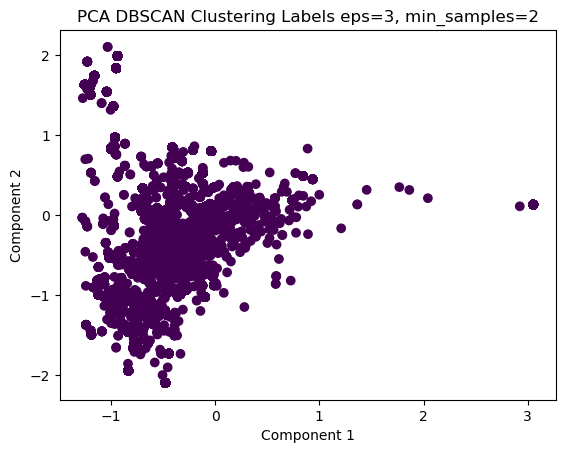

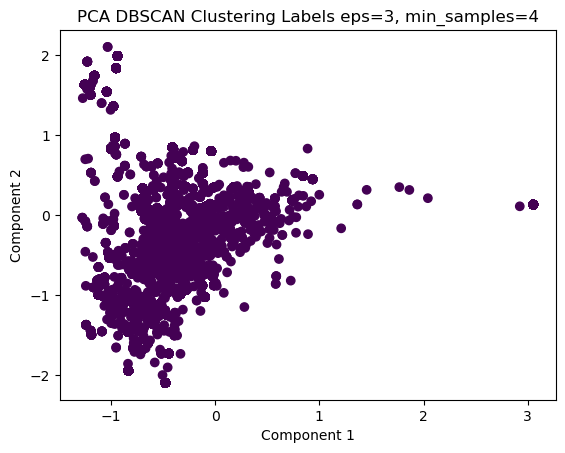

In [40]:
for i in range(0, len(eps)):
    # Plotting PCA visualization with DBSCAN labels
    plt.scatter(pca_df.iloc[:, 0], pca_df.iloc[:, 1], c=dbscan_pca_labels_collection[i])
    plt.title(
        f"PCA DBSCAN Clustering Labels eps={eps[i]}, min_samples={min_samples[i]}"
    )
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

In [41]:
score_fail = []

# Try to compute the silhouette score for each combination of eps and min_samples
for i in range(0, len(eps)):
    try:
        score = silhouette_score(pca_df, dbscan_pca_labels_collection[i])
    except ValueError as e:
        print(
            f"Silhouette Score for PCA DBSCAN Clustering eps={eps[i]}, min_samples={min_samples[i]}: -"
        )
        note = f"Can't compute Silhouette Score for PCA DBSCAN Clustering eps={eps[i]}, min_samples={min_samples[i]}: {e}"
        score_fail.append(note)
        continue

    scores[f"DBSCAN with PCA eps={eps[i]}, min_samples={min_samples[i]}"] = score
    print(
        f"Silhouette Score for PCA DBSCAN Clustering eps={eps[i]}, min_samples={min_samples[i]}: {score}"
    )

Silhouette Score for PCA DBSCAN Clustering eps=0.75, min_samples=2: 0.5165822371721824
Silhouette Score for PCA DBSCAN Clustering eps=0.5, min_samples=2: -0.0868118088584869
Silhouette Score for PCA DBSCAN Clustering eps=0.31, min_samples=2: 0.21502795342628078
Silhouette Score for PCA DBSCAN Clustering eps=0.31, min_samples=4: 0.21502795342628078
Silhouette Score for PCA DBSCAN Clustering eps=0.75, min_samples=4: 0.5165822371721824
Silhouette Score for PCA DBSCAN Clustering eps=1, min_samples=2: -
Silhouette Score for PCA DBSCAN Clustering eps=1, min_samples=4: -
Silhouette Score for PCA DBSCAN Clustering eps=0.5, min_samples=4: -0.0868118088584869
Silhouette Score for PCA DBSCAN Clustering eps=2, min_samples=2: -
Silhouette Score for PCA DBSCAN Clustering eps=2, min_samples=4: -
Silhouette Score for PCA DBSCAN Clustering eps=3, min_samples=2: -
Silhouette Score for PCA DBSCAN Clustering eps=3, min_samples=4: -


In [42]:
# Report any failed score attempts
for i in range(0, len(score_fail)):
    print(score_fail[i])

Can't compute Silhouette Score for PCA DBSCAN Clustering eps=1, min_samples=2: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Can't compute Silhouette Score for PCA DBSCAN Clustering eps=1, min_samples=4: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Can't compute Silhouette Score for PCA DBSCAN Clustering eps=2, min_samples=2: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Can't compute Silhouette Score for PCA DBSCAN Clustering eps=2, min_samples=4: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Can't compute Silhouette Score for PCA DBSCAN Clustering eps=3, min_samples=2: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Can't compute Silhouette Score for PCA DBSCAN Clustering eps=3, min_samples=4: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)


# T-SNE

- Keep number of components for t-sne to less than 4, because the main idea of t-sne is to visualize high-dimesional dataset into 2D or 3D

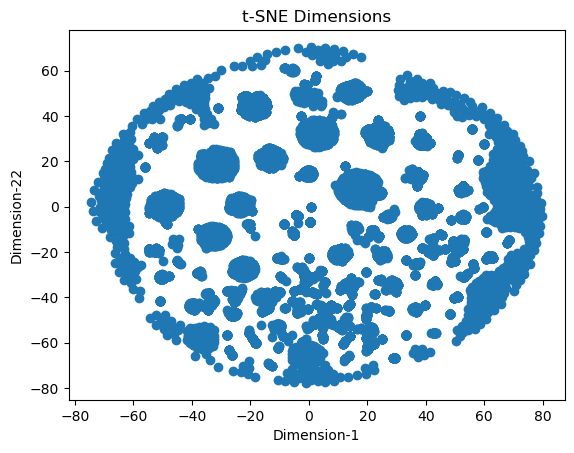

In [43]:
# creating t-SNE object
tsne = TSNE(n_components=2, random_state=42, init="random")

# fitting t-SNE to standardized data
tsne_results = tsne.fit_transform(feature_matrix)

# plotting the t-SNE components
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xlabel("Dimension-1")
plt.ylabel("Dimension-22")
plt.title("t-SNE Dimensions")
plt.show()

# tSNE KMeans Clustering

In [44]:
# applying KMeans clustering to the t-SNE components
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tsne_results)
    inertias.append(kmeans.inertia_)

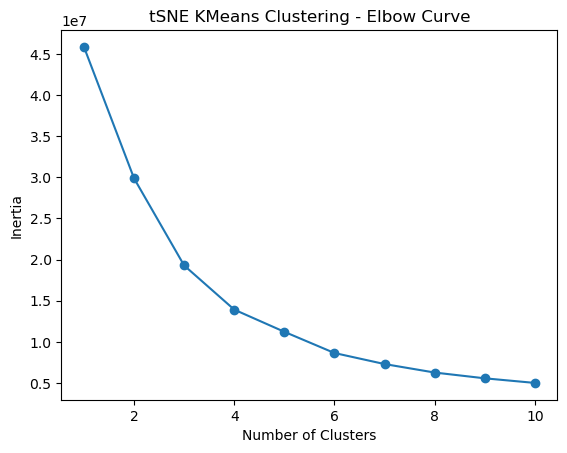

In [45]:
# plotting the elbow curve
plt.plot(range(1, 11), inertias, marker="o")
plt.title("tSNE KMeans Clustering - Elbow Curve")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

In [46]:
# choosing the appropriate number of clusters
k = 3

# performing KMeans clustering with chosen number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
tsne_labels = kmeans.fit_predict(tsne_results)

In [47]:
# adding cluster labels to the sentence df
sentences_df["tSNE_CLUSTER"] = tsne_labels

In [48]:
sentences_df[["tSNE_CLUSTER", "SENTENCE"]]

tSNE_CLUSTER                                           SENTENCE
0                 0  IT WAS REPORTED THAT THE TRANSMITTER LOST CONN...
1                 0  THE TRANSMITTER ULTIMATELY REGAINED CONNECTION...
2                 0  NO ADDITIONAL PATIENT OR EVENT INFORMATION WAS...
3                 2  IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...
4                 2    NO PRODUCT OR DATA WAS PROVIDED FOR EVALUATION.
...             ...                                                ...
25681             2  IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...
25682             2                  DATA WAS RECEIVED FOR EVALUATION.
25683             1  HOWEVER, THE ALLEGED PRODUCT IS NOT PRESENT WI...
25684             2  CONFIRMATION OF THE ALLEGATION AND A PROBABLE ...
25685             2    NO INJURY OR MEDICAL INTERVENTION WAS REPORTED.

[25686 rows x 2 columns]

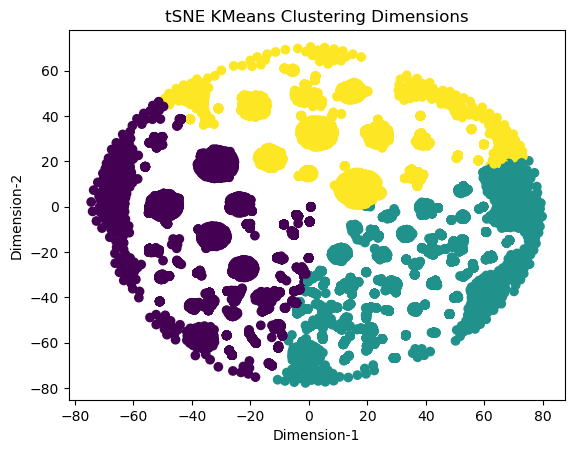

In [49]:
# ploting the data using t-SNE components and color by clustering labels
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=tsne_labels)
plt.xlabel("Dimension-1")
plt.ylabel("Dimension-2")
plt.title("tSNE KMeans Clustering Dimensions")
plt.show()

In [50]:
# Compute the silhouette score
score = silhouette_score(tsne_results, tsne_labels)
scores["tSNE KMeans Clustering"] = score

print("Silhouette Score for Kmeans with T-sne: ", score)

Silhouette Score for Kmeans with T-sne:  0.3695673


# tSNE DBSCAN Clustering

## Build a k-distance graph to determine the optimal value of "EPS" using the elbow method

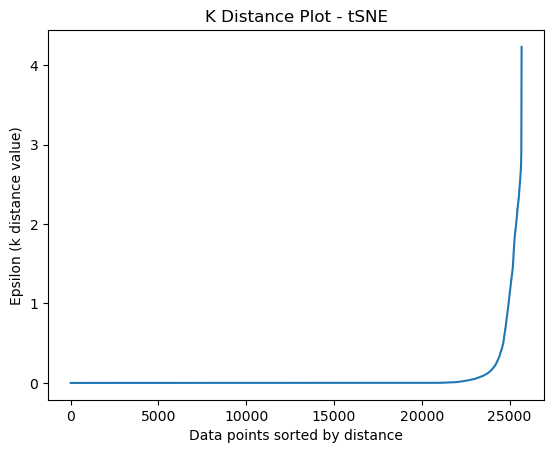

In [51]:
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(tsne_results)
distances, indices = neighbors_fit.kneighbors(tsne_results)

distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.xlabel("Data points sorted by distance")
plt.ylabel("Epsilon (k distance value)")
plt.title("K Distance Plot - tSNE")
plt.plot(distances)

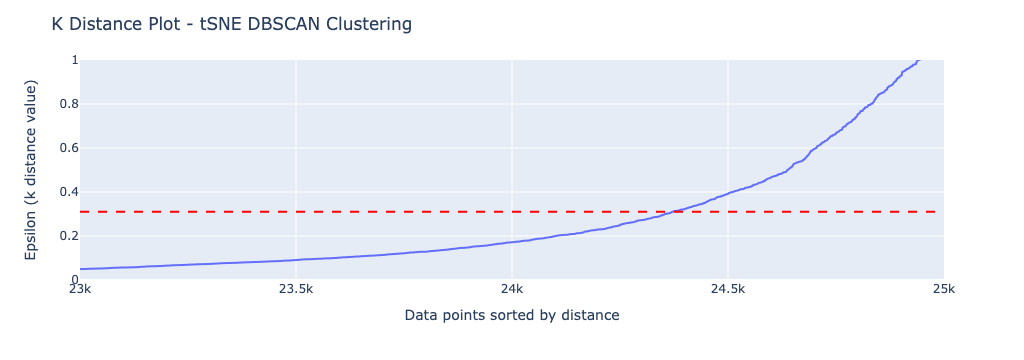

In [52]:
fig_2 = px.line(distances)

# set the limits of the y-axis to: 0 to 1
fig_2.update_yaxes(range=[0, 1])

# set the limits of the x-axis to: 23000 to 25000
fig_2.update_xaxes(range=[23000, 25000])

# add a horizontal rule for y = 0.31
fig_2.add_shape(
    type="line",
    x0=0,
    y0=0.31,
    x1=25000,
    y1=0.31,
    line=dict(color="red", width=2, dash="dash"),
)

fig_2.update_layout(
    title="K Distance Plot - tSNE DBSCAN Clustering",
    xaxis_title="Data points sorted by distance",
    yaxis_title="Epsilon (k distance value)",
    showlegend=False,
)

# write the graph to a file in the working directory
fig_2.write_html(f"{working_directory}/dbscan_parameter_estimation_for_tsne_{TAG}.html")

# show the plot
fig_2.show()

## Perform DBSCAN clustering

In [53]:
dbscan = DBSCAN(eps=0.31, min_samples=4)
dbscan_labels = dbscan.fit_predict(tsne_results)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


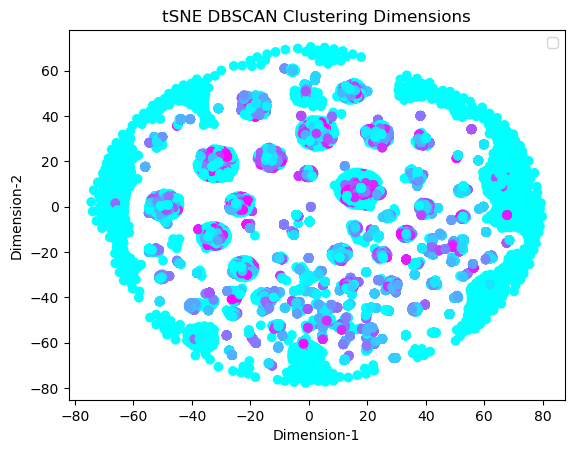

In [54]:
# Plot t-SNE visualization with  DBSCAN labels
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=dbscan_labels, cmap="cool")
plt.title("tSNE DBSCAN Clustering Dimensions")
plt.xlabel("Dimension-1")
plt.ylabel("Dimension-2")
plt.legend()
plt.show()

In [55]:
# Compute the silhouette score
score = silhouette_score(tsne_results, dbscan_labels)
scores["tSNE DBSCAN Clustering"] = score

print("Silhouette Score for tSNE DBSCAN Clustering: ", score)

Silhouette Score for tSNE DBSCAN Clustering:  0.71539605


In [56]:
dbscan_clusters_number = np.unique(dbscan_labels)
print("Number of clusters find by dbscan {}".format(len(dbscan_clusters_number)))

Number of clusters find by dbscan 1016


In [57]:
# adding cluster labels to the sentence df
sentences_df["tSNE_with_DBSCAN_CLUSTER"] = dbscan_labels

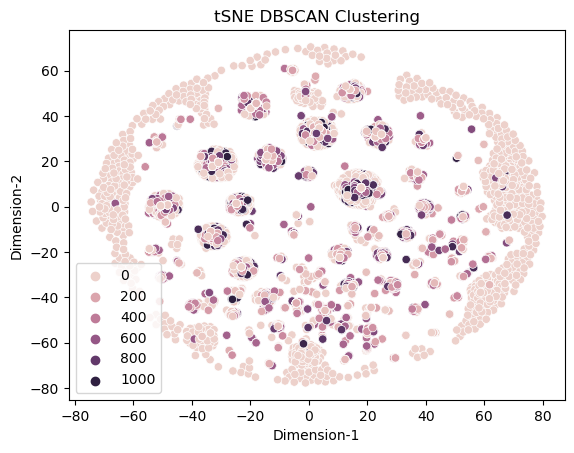

In [58]:
# Plot t-SNE visualization with  DBSCAN labels
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1], hue=dbscan_labels, cmap="cool"
)
plt.title("tSNE DBSCAN Clustering")
plt.xlabel("Dimension-1")
plt.ylabel("Dimension-2")
plt.legend()
plt.show()

# Hybrid PCA and tSNE KMeans Clustering

In [59]:
# Applying PCA to reduce the dimensionality of the data
pca = PCA(n_components=10)
pca_data = pca.fit_transform(feature_matrix)

# Applying t-SNE for visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_data = tsne.fit_transform(pca_data)

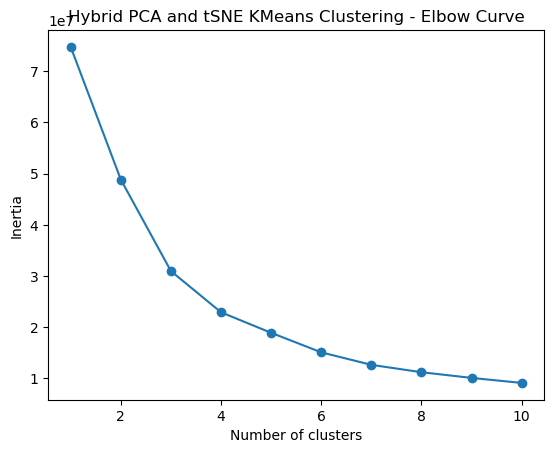

In [60]:
# Determining the optimal number of clusters using the elbow method
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tsne_data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 11), inertias, marker="o")
plt.title("Hybrid PCA and tSNE KMeans Clustering - Elbow Curve")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

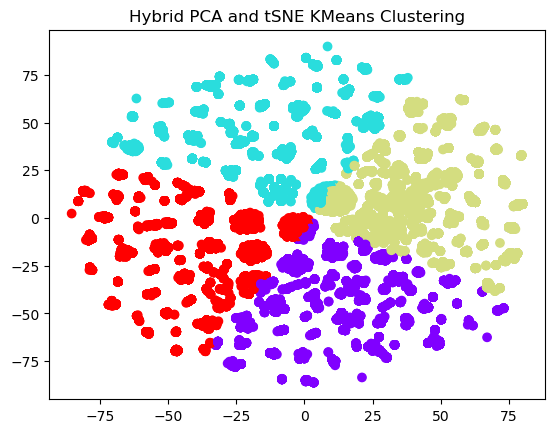

In [61]:
# Run k-means clustering with the optimal number of clusters
k = 4  # Change this to the optimal number of clusters determined by the elbow method
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(tsne_data)
pca_tsne_labels = kmeans.fit_predict(tsne_data)

# Plot the data points with the assigned cluster labels
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=pca_tsne_labels, cmap="rainbow")
plt.title("Hybrid PCA and tSNE KMeans Clustering")
plt.show()

In [62]:
# adding cluster labels to the sentence df
sentences_df["PCA_tSNE_CLUSTER"] = pca_tsne_labels

In [63]:
# Compute the silhouette score
score = silhouette_score(tsne_data, pca_tsne_labels)
scores["Hybrid PCA and tSNE KMeans Clustering"] = score

print("Silhouette Score for Hybrid PCA and tSNE KMeans Clustering: ", score)

Silhouette Score for Hybrid PCA and tSNE KMeans Clustering:  0.34657162


## Build a k-distance graph to determine the optimal value of "EPS" using the elbow method

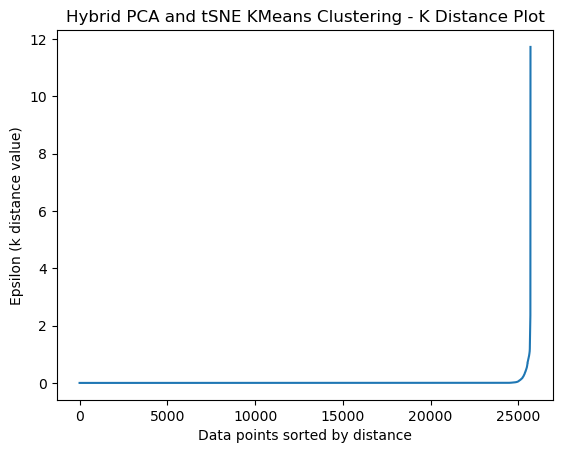

In [64]:
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(tsne_data)
distances, indices = neighbors_fit.kneighbors(tsne_data)

distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.xlabel("Data points sorted by distance")
plt.ylabel("Epsilon (k distance value)")
plt.title("Hybrid PCA and tSNE KMeans Clustering - K Distance Plot")
plt.plot(distances)

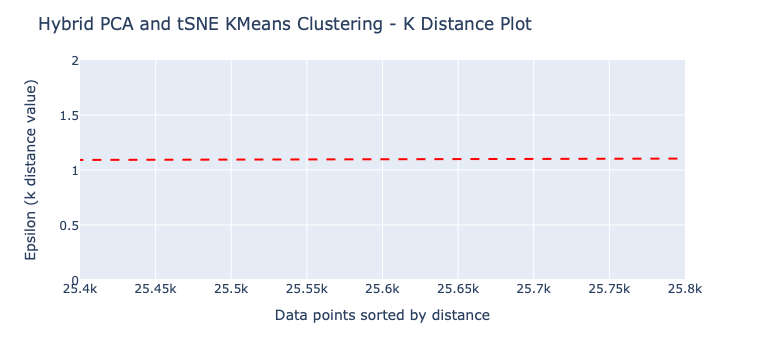

In [65]:
fig_3 = px.line(distances)

# set the limits of the y-axis to: 0 to 1
fig_3.update_yaxes(range=[0, 2])

# set the limits of the x-axis to: 25400 to 25800
fig_3.update_xaxes(range=[25400, 25800])

# add a horizontal rule for y = 1.11
fig_3.add_shape(
    type="line",
    x0=0,
    y0=0.31,
    x1=26000,
    y1=1.11,
    line=dict(color="red", width=2, dash="dash"),
)

fig_3.update_layout(
    title="Hybrid PCA and tSNE KMeans Clustering - K Distance Plot",
    xaxis_title="Data points sorted by distance",
    yaxis_title="Epsilon (k distance value)",
    showlegend=False,
)

# write the graph to a file in the working directory
fig_3.write_html(
    f"{working_directory}/dbscan_parameter_estimation_for_pca_and_tsne_{TAG}.html"
)

# show the plot
fig_3.show()

# Hybrid PCA and tSNE DBSCAN Clustering

In [66]:
# Performing DBSCAN clustering on the t-sne data
dbscan_pca_tsne = DBSCAN(eps=1.11, min_samples=4)
dbscan_labels_pca_tsne = dbscan_pca_tsne.fit_predict(tsne_data)

In [67]:
dbscan_labels_pca_tsne_clusters_number = np.unique(dbscan_labels_pca_tsne)
print(
    "Number of clusters find by dbscan {}".format(
        len(dbscan_labels_pca_tsne_clusters_number)
    )
)

Number of clusters find by dbscan 673


In [68]:
# adding cluster labels to the sentence df
sentences_df["PCA_tSNE_with_DBSCAN_CLUSTER"] = dbscan_labels_pca_tsne

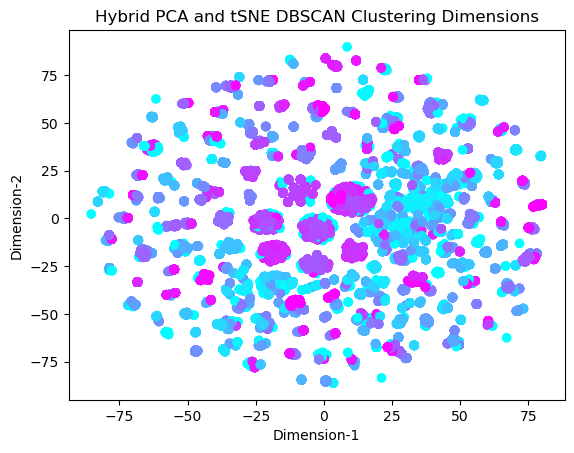

In [69]:
# Plot t-SNE visualization with  DBSCAN labels
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=dbscan_labels_pca_tsne, cmap="cool")
plt.title("Hybrid PCA and tSNE DBSCAN Clustering Dimensions")
plt.xlabel("Dimension-1")
plt.ylabel("Dimension-2")
plt.show()

In [70]:
# Compute the silhouette score
score = silhouette_score(tsne_data, dbscan_labels_pca_tsne)
scores["Hybrid PCA and tSNE DBSCAN Clustering"] = score

print("Silhouette Score for Hybrid PCA and tSNE DBSCAN Clustering: ", score)

Silhouette Score for Hybrid PCA and tSNE DBSCAN Clustering:  0.8550143


## Summary

In [71]:
scores_df = pd.DataFrame.from_dict(scores, orient="index", columns=["Value"])
scores_df.sort_values(by="Value", ascending=False)

Value
Hybrid PCA and tSNE DBSCAN Clustering    0.855014
tSNE DBSCAN Clustering                   0.715396
PCA KMeans Clustering                    0.622903
DBSCAN with PCA eps=0.75, min_samples=2  0.516582
DBSCAN with PCA eps=0.75, min_samples=4  0.516582
tSNE KMeans Clustering                   0.369567
Hybrid PCA and tSNE KMeans Clustering    0.346572
DBSCAN with PCA eps=0.31, min_samples=2  0.215028
DBSCAN with PCA eps=0.31, min_samples=4  0.215028
DBSCAN with PCA eps=0.5, min_samples=2  -0.086812
DBSCAN with PCA eps=0.5, min_samples=4  -0.086812

In [72]:
print(f"Largest value is {scores_df.loc[scores_df['Value'].idxmax()]}")

Largest value is Value    0.855014
Name: Hybrid PCA and tSNE DBSCAN Clustering, dtype: float64


In [73]:
# Write the sentences dataframe to a CSV file
sentences_df.to_csv(f"{working_directory}/sentences_dataframe_{TAG}.csv", index=False)

# Write the sentences dataframe to a pickle
sentences_df.to_pickle(f"{working_directory}/sentences_dataframe_{TAG}.pickle")

## Upload All Output to an S3 Bucket

In [ ]:
upload_to_s3()